In [71]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import json

from pathlib import Path
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline
warnings.filterwarnings('ignore')

# 데이터 로드

In [7]:
DATA_IN_PATH = './data_in/'

In [66]:
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')

In [10]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# EDA

In [11]:
print('전체 학습 데이터의 개수 : {}'.format(len(train_data)))

전체 학습 데이터의 개수 : 404290


In [12]:
train_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)
train_set

0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor (Koh-i-Noor) Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely? How can I solve...
4         Which one dissolve in water quikly sugar, salt...
                                ...                        
808575    How many keywords are there in PERL Programmin...
808576           Is it true that there is life after death?
808577                                    What's this coin?
808578    I am having little hairfall problem but I want...
808579        What is it like to have sex with your cousin?
Length: 808580, dtype: object

In [13]:
print('데이터의 총 질문 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 질문의 수 : {}'.format(np.sum(train_set.value_counts()>1)))

데이터의 총 질문 수 : 537361
반복해서 나타나는 질문의 수 : 111873


Text(0, 0.5, 'Number of questions')

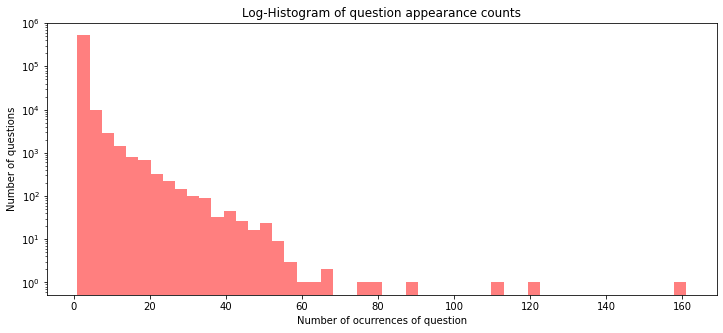

In [15]:
# 중복되는 질문의 분포
plt.figure(figsize=(12, 5))
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of ocurrences of question')
plt.ylabel('Number of questions')

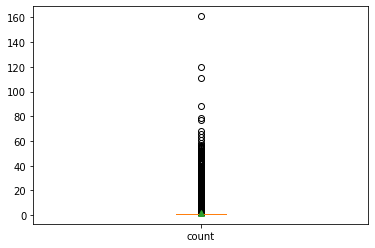

In [20]:
plt.boxplot(train_set.value_counts(), labels=['count'], showmeans=True)
plt.show()

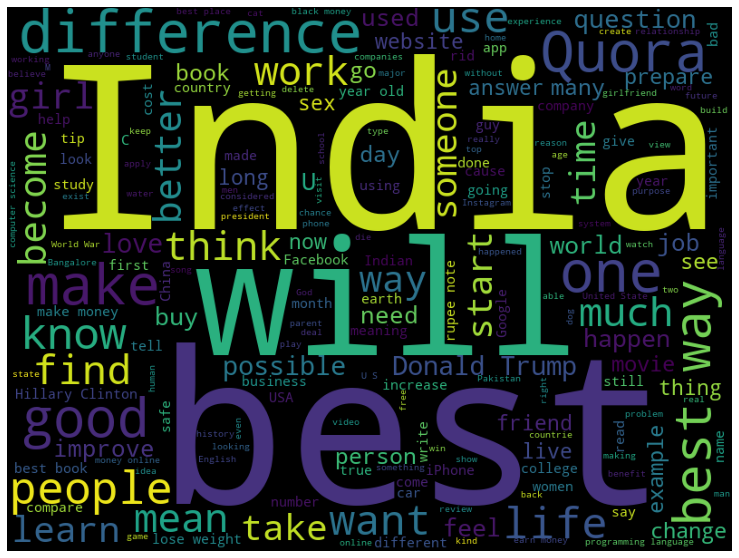

In [21]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [31]:
train_length = train_set.apply(len)

In [35]:
from matplotlib import rc
import matplotlib.font_manager as fm

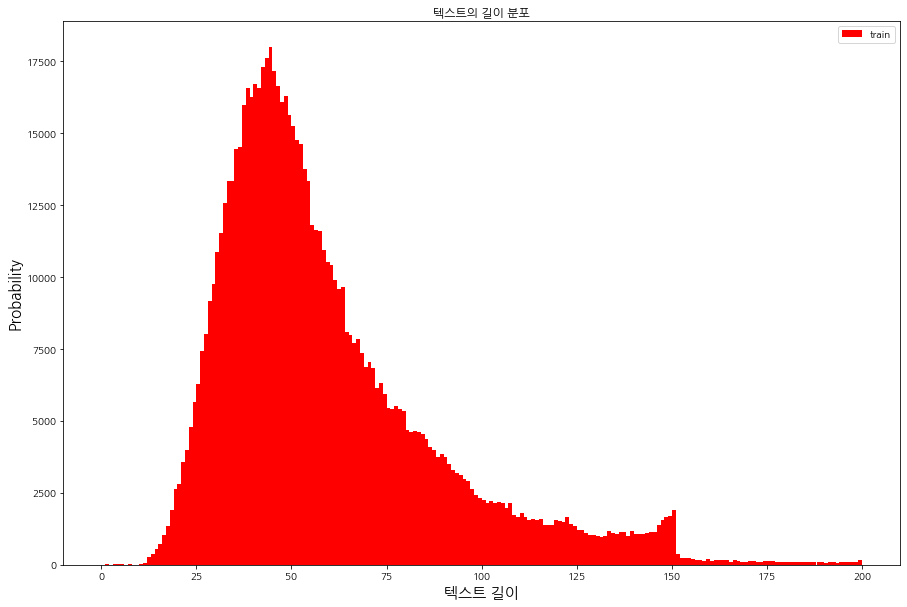

In [46]:
fm.get_fontconfig_fonts()

# 디렉토리 및 파일 이름에 맞추어 변경
font_location = 'C:\\WINDOWS\\Fonts\\NanumGothicBold.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
# 텍스트의 길이
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0, 200], facecolor='r', label='train')
plt.title('텍스트의 길이 분포')
plt.legend()
plt.xlabel('텍스트 길이', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

In [44]:
train_word_counts = train_set.apply(lambda x : len(x.split(' ')))

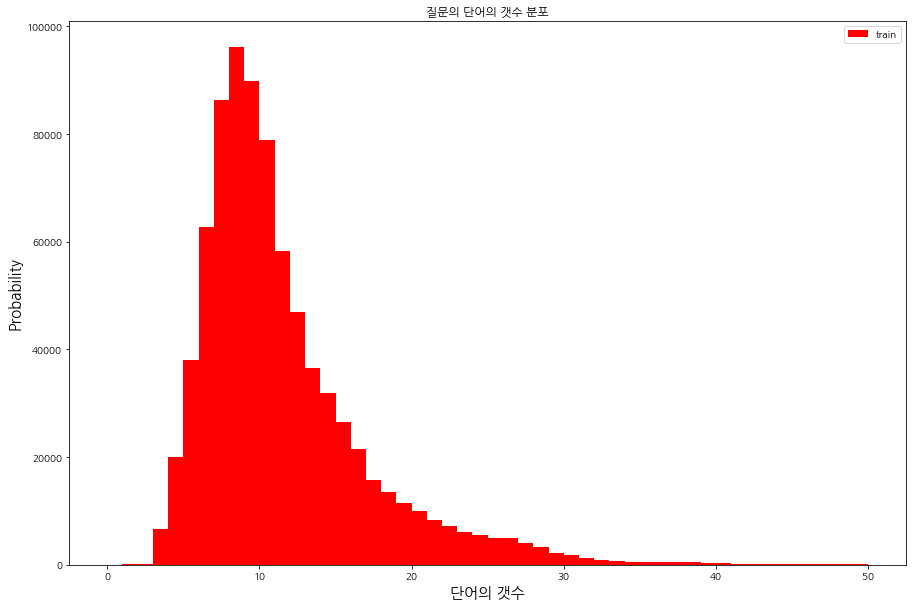

In [47]:
# 단어의 갯수
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', label='train')
plt.title('질문의 단어의 갯수 분포')
plt.legend()
plt.xlabel('단어의 갯수', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.show()

# 데이터 전처리

In [62]:
train_pos_data = train_data.loc[train_data['is_duplicate'] == 1]
train_neg_data = train_data.loc[train_data['is_duplicate'] == 0]

In [63]:
len(train_pos_data), len(train_neg_data)

(149263, 255027)

In [64]:
# 데이터 비율 맞추기
class_difference = len(train_neg_data) - len(train_pos_data)
sample_frac = 1-(class_difference / len(train_neg_data))

train_neg_data = train_neg_data.sample(frac=sample_frac)

In [68]:
train = train_data.copy()

In [69]:
train = pd.concat([train_neg_data, train_pos_data])

In [73]:
FILTERS = "([~.,!?\"':;)(])"
change_filter = re.compile(FILTERS)

In [74]:
question1 = [str(s) for s in train['question1']]
question2 = [str(s) for s in train['question2']]

filtered_question1 = list()
filtered_question2 = list()

for q in question1 :
    filtered_question1.append(re.sub(change_filter,"", q).lower())
    
for q in question2 :
    filtered_question2.append(re.sub(change_filter,"", q).lower())

In [75]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_question1 + filtered_question2)

In [76]:
questions1_sequence = tokenizer.texts_to_sequences(filtered_question1)
questions2_sequence = tokenizer.texts_to_sequences(filtered_question2)

In [78]:
MAX_SEQUENCE_LENGTH = 31

q1_data = pad_sequences(questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
q2_data = pad_sequences(questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [81]:
word_vocab = {}
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

labels = np.array(train['is_duplicate'], dtype=int)

print('Shape of question1 data : {}'.format(q1_data.shape))
print('Shape of question2 data : {}'.format(q2_data.shape))
print('Shape of label : {}'.format(labels.shape))
print('Words in index : {}'.format(len(word_vocab)))

Shape of question1 data : (298526, 31)
Shape of question2 data : (298526, 31)
Shape of label : (298526,)
Words in index : 76518


In [88]:
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

In [89]:
TRAIN_Q1_DATA = 'q1_train.npy'
TRAIN_Q2_DATA = 'q2_train.npy'
TRAIN_LABEL_DATA = 'label_train.npy'
DATA_CONFIGS = 'data_configs.npy'

np.save(open(DATA_IN_PATH + TRAIN_Q1_DATA, 'wb'), q1_data)
np.save(open(DATA_IN_PATH + TRAIN_Q2_DATA, 'wb'), q2_data)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), labels)
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

In [90]:
test_data = pd.read_csv(DATA_IN_PATH + 'test.csv', encoding='utf-8')
valid_ids = [type(x) == int for x in test_data.test_id]
test_data = test_data[valid_ids].drop_duplicates()

In [92]:
test_question1 = [str(s) for s in test_data['question1']]
test_question2 = [str(s) for s in test_data['question2']]

filtered_test_question1 = []
filtered_test_question2 = []

for q in test_question1 :
    filtered_test_question1.append(re.sub(change_filter, "", q).lower())
    
for q in test_question2 :
    filtered_test_question2.append(re.sub(change_filter, "", q).lower())

In [94]:
test_questions1_sequence = tokenizer.texts_to_sequences(filtered_test_question1)
test_questions2_sequence = tokenizer.texts_to_sequences(filtered_test_question2)

test_q1_data = pad_sequences(test_questions1_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_q2_data = pad_sequences(test_questions2_sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [95]:
test_id = np.array(test_data['test_id'])

In [96]:
TEST_Q1_DATA = 'test_q1.npy'
TEST_Q2_DATA = 'test_q2.npy'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_Q1_DATA, 'wb'), test_q1_data)
np.save(open(DATA_IN_PATH + TEST_Q2_DATA, 'wb'), test_q2_data)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'), test_id)

# 모델링

## XGBoost

In [105]:
train_q1_data = np.load(open(DATA_IN_PATH + TRAIN_Q1_DATA, 'rb'))
train_q2_data = np.load(open(DATA_IN_PATH + TRAIN_Q2_DATA, 'rb'))
train_labels = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))

In [106]:
train_input = np.stack((train_q1_data, train_q2_data), axis=1)
train_input.shape

(298526, 2, 31)

In [109]:
from sklearn.model_selection import train_test_split

train_input, eval_input, train_label, eval_label = train_test_split(train_input, train_labels, test_size=0.2, random_state=4242)

In [110]:
import xgboost as xgb

train_data = xgb.DMatrix(train_input.sum(axis=1), label=train_label)
eval_data = xgb.DMatrix(eval_input.sum(axis=1), label=eval_label)

data_list = [(train_data, 'train'), (eval_data, 'valid')]

In [114]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'rmse'

bst = xgb.train(params, train_data, num_boost_round=1000, evals=data_list, early_stopping_rounds=10)

[0]	train-rmse:0.48377	valid-rmse:0.48446
[1]	train-rmse:0.47335	valid-rmse:0.47461
[2]	train-rmse:0.46674	valid-rmse:0.46834
[3]	train-rmse:0.46208	valid-rmse:0.46391
[4]	train-rmse:0.45829	valid-rmse:0.46050
[5]	train-rmse:0.45523	valid-rmse:0.45768
[6]	train-rmse:0.45272	valid-rmse:0.45530
[7]	train-rmse:0.45106	valid-rmse:0.45379
[8]	train-rmse:0.44953	valid-rmse:0.45248
[9]	train-rmse:0.44748	valid-rmse:0.45063
[10]	train-rmse:0.44644	valid-rmse:0.44981
[11]	train-rmse:0.44538	valid-rmse:0.44884
[12]	train-rmse:0.44462	valid-rmse:0.44831
[13]	train-rmse:0.44297	valid-rmse:0.44678
[14]	train-rmse:0.44228	valid-rmse:0.44622
[15]	train-rmse:0.44154	valid-rmse:0.44571
[16]	train-rmse:0.44098	valid-rmse:0.44542
[17]	train-rmse:0.44054	valid-rmse:0.44511
[18]	train-rmse:0.44010	valid-rmse:0.44477
[19]	train-rmse:0.43808	valid-rmse:0.44292
[20]	train-rmse:0.43768	valid-rmse:0.44258
[21]	train-rmse:0.43741	valid-rmse:0.44248
[22]	train-rmse:0.43707	valid-rmse:0.44222
[23]	train-rmse:0.436

[189]	train-rmse:0.40153	valid-rmse:0.42484
[190]	train-rmse:0.40151	valid-rmse:0.42484
[191]	train-rmse:0.40121	valid-rmse:0.42480
[192]	train-rmse:0.40087	valid-rmse:0.42464
[193]	train-rmse:0.40051	valid-rmse:0.42449
[194]	train-rmse:0.40025	valid-rmse:0.42447
[195]	train-rmse:0.40003	valid-rmse:0.42440
[196]	train-rmse:0.39994	valid-rmse:0.42443
[197]	train-rmse:0.39965	valid-rmse:0.42425
[198]	train-rmse:0.39940	valid-rmse:0.42426
[199]	train-rmse:0.39917	valid-rmse:0.42427
[200]	train-rmse:0.39896	valid-rmse:0.42421
[201]	train-rmse:0.39891	valid-rmse:0.42419
[202]	train-rmse:0.39879	valid-rmse:0.42417
[203]	train-rmse:0.39865	valid-rmse:0.42415
[204]	train-rmse:0.39857	valid-rmse:0.42416
[205]	train-rmse:0.39841	valid-rmse:0.42412
[206]	train-rmse:0.39837	valid-rmse:0.42411
[207]	train-rmse:0.39827	valid-rmse:0.42406
[208]	train-rmse:0.39825	valid-rmse:0.42404
[209]	train-rmse:0.39808	valid-rmse:0.42399
[210]	train-rmse:0.39799	valid-rmse:0.42397
[211]	train-rmse:0.39792	valid-r

[376]	train-rmse:0.37673	valid-rmse:0.41948
[377]	train-rmse:0.37669	valid-rmse:0.41949
[378]	train-rmse:0.37669	valid-rmse:0.41948
[379]	train-rmse:0.37668	valid-rmse:0.41948
[380]	train-rmse:0.37668	valid-rmse:0.41948
[381]	train-rmse:0.37656	valid-rmse:0.41948
[382]	train-rmse:0.37652	valid-rmse:0.41947
[383]	train-rmse:0.37642	valid-rmse:0.41944
[384]	train-rmse:0.37635	valid-rmse:0.41946
[385]	train-rmse:0.37626	valid-rmse:0.41945
[386]	train-rmse:0.37625	valid-rmse:0.41944
[387]	train-rmse:0.37624	valid-rmse:0.41944
[388]	train-rmse:0.37623	valid-rmse:0.41944
[389]	train-rmse:0.37619	valid-rmse:0.41943
[390]	train-rmse:0.37610	valid-rmse:0.41942
[391]	train-rmse:0.37607	valid-rmse:0.41942
[392]	train-rmse:0.37599	valid-rmse:0.41943
[393]	train-rmse:0.37588	valid-rmse:0.41940
[394]	train-rmse:0.37579	valid-rmse:0.41938
[395]	train-rmse:0.37577	valid-rmse:0.41937
[396]	train-rmse:0.37571	valid-rmse:0.41935
[397]	train-rmse:0.37570	valid-rmse:0.41935
[398]	train-rmse:0.37555	valid-r

[563]	train-rmse:0.35954	valid-rmse:0.41689
[564]	train-rmse:0.35943	valid-rmse:0.41692
[565]	train-rmse:0.35940	valid-rmse:0.41691
[566]	train-rmse:0.35933	valid-rmse:0.41692
[567]	train-rmse:0.35929	valid-rmse:0.41691
[568]	train-rmse:0.35928	valid-rmse:0.41690
[569]	train-rmse:0.35910	valid-rmse:0.41686
[570]	train-rmse:0.35895	valid-rmse:0.41685
[571]	train-rmse:0.35893	valid-rmse:0.41684
[572]	train-rmse:0.35890	valid-rmse:0.41682
[573]	train-rmse:0.35889	valid-rmse:0.41681
[574]	train-rmse:0.35870	valid-rmse:0.41682
[575]	train-rmse:0.35863	valid-rmse:0.41680
[576]	train-rmse:0.35851	valid-rmse:0.41676
[577]	train-rmse:0.35835	valid-rmse:0.41672
[578]	train-rmse:0.35823	valid-rmse:0.41670
[579]	train-rmse:0.35822	valid-rmse:0.41671
[580]	train-rmse:0.35817	valid-rmse:0.41670
[581]	train-rmse:0.35802	valid-rmse:0.41670
[582]	train-rmse:0.35798	valid-rmse:0.41669
[583]	train-rmse:0.35791	valid-rmse:0.41668
[584]	train-rmse:0.35777	valid-rmse:0.41664
[585]	train-rmse:0.35763	valid-r

In [123]:
test_q1_data = np.load(open(DATA_IN_PATH + TEST_Q1_DATA, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + TEST_Q2_DATA, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

In [124]:
test_input = np.stack((test_q1_data, test_q2_data), axis=1)
test_data = xgb.DMatrix(test_input.sum(axis=1))
test_predict = bst.predict(test_data)

In [127]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH) :
    os.makedirs(DATA_OUT_PATH)
    
output = pd.DataFrame({'test_id':test_id_data, 'is_duplicate': test_predict})
output.to_csv(DATA_OUT_PATH + 'simple_xgb.csv', index=False)